In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
import time as time
import tensorflow.keras.preprocessing.image as image
import matplotlib.pyplot as plt
import os
from scipy.io import loadmat
import pandas as pd
import numpy as np
from sklearn import preprocessing  # 0-1编码
from sklearn.model_selection import StratifiedShuffleSplit  # 随机划分，保证每一类比例相同
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.initializers import glorot_uniform
import matplotlib.pyplot as plt
from prettytable import PrettyTable
import six
import math
from matplotlib.pyplot import MultipleLocator
from sklearn.metrics import classification_report
from matplotlib.font_manager import FontProperties
from sklearn.impute import SimpleImputer
from einops.layers.tensorflow import Rearrange

### by Zg,Henan University of Technology

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
(X_train,y_train),(X_test,y_test)=tf.keras.datasets.cifar10.load_data()

In [4]:
def plotImages(images_arr):
    fig, axes = plt.subplots(2, 5, figsize=(20, 10))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

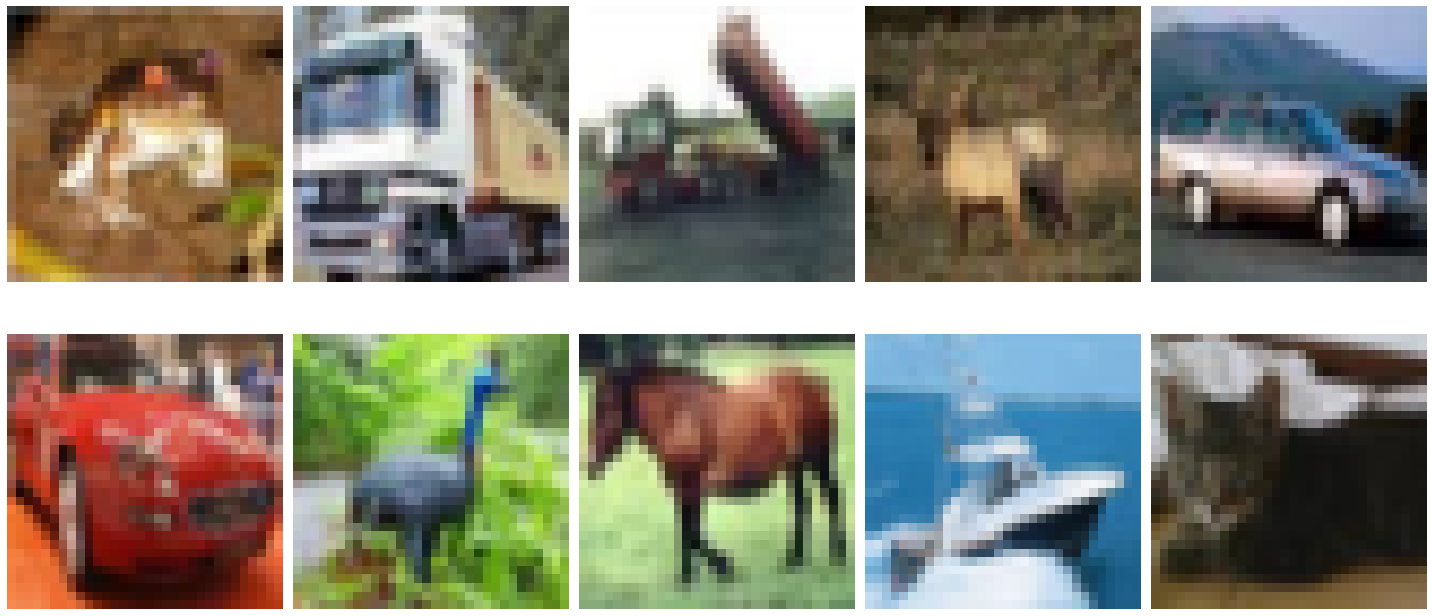

In [5]:
plotImages(X_train[:10])

In [6]:
X_train =  StandardScaler().fit_transform(X_train.astype(np.float32).reshape(-1,1)).reshape(-1,32,32,3)
X_test =  StandardScaler().fit_transform(X_test.astype(np.float32).reshape(-1,1)).reshape(-1,32,32,3)

In [7]:
X_train_ = np.transpose(X_train,(0,3,1,2))
X_test_ = np.transpose(X_test,(0,3,1,2))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

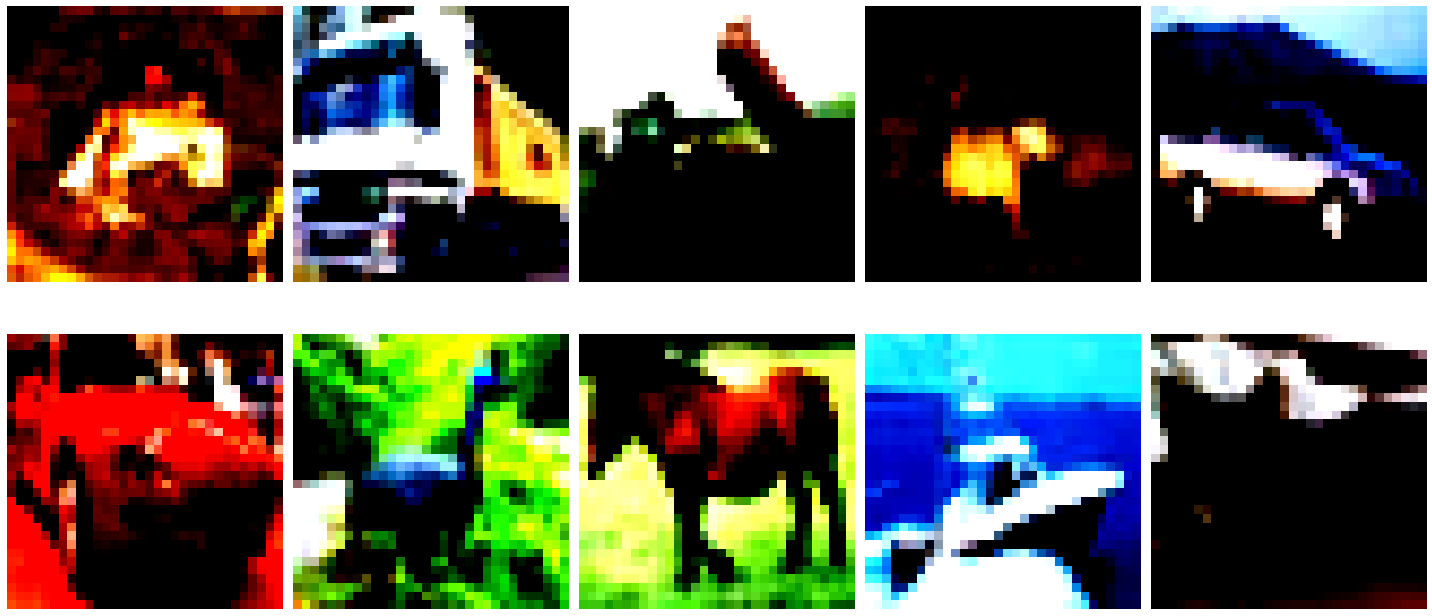

In [8]:
plotImages(X_train[:10])

In [9]:
y_train_ = tf.keras.utils.to_categorical(y_train,10)
y_test_ = tf.keras.utils.to_categorical(y_test,10)

In [10]:
def feed_forward_network(d_model, dff):#dff:dim of feed_forward_network
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),
        tf.keras.layers.Dense(d_model)
    ])
def get_activation(identifier):

    if isinstance(identifier, six.string_types):
        name_to_fn = {"gelu": gelu}
        identifier = str(identifier).lower()
        if identifier in name_to_fn:
            return tf.keras.activations.get(name_to_fn[identifier])
    return tf.keras.activations.get(identifier)

def gelu(x):

    cdf = 0.5 * (1.0 + tf.tanh(
        (math.sqrt(2 / math.pi) * (x + 0.044715 * tf.pow(x, 3)))))
    return x * cdf
# 构造mutil head attention层
class MutilHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads,max_lenth): # d_model:model的维度, num_heads:多头的头数
        super(MutilHeadAttention, self).__init__()
        
        self.num_heads = num_heads #属性
        self.d_model = d_model
        self.scale = d_model ** -0.5
        self.max_lenth = max_lenth
        self.to_qkv = tf.keras.layers.Dense(d_model * 3, use_bias=False)
        self.to_out = tf.keras.layers.Dense(d_model)
        
        self.rearrange_qkv = Rearrange('batch max_lenth (qkv heads depth) -> qkv batch heads max_lenth depth',
                                       qkv = 3, heads = self.num_heads) #(64*3=192),h=8,qkv=3,depth=8
        self.rearrange_out = Rearrange('batch heads max_lenth depth -> batch max_lenth (heads depth)')
        
    def call(self,x):
        qkv = self.to_qkv(x)  # batch,max_lenth,d_model --> batch,max_lenth,3*d_model
        qkv = self.rearrange_qkv(qkv) # batch,max_lenth,3*d_model --> 3,batch,heads,max_lenth,depth
        q = qkv[0] # batch,heads,max_lenth,depth
        k = qkv[1] #batch,heads,max_lenth,depth
        v = qkv[2] #batch,heads,max_lenth,depth
        
        dots = tf.einsum('bhid,bhjd->bhij', q, k) * self.scale 
        attn = tf.nn.softmax(dots,axis=-1)
        out = tf.einsum('bhij,bhjd->bhid', attn, v)
        out = self.rearrange_out(out) #  batch heads max_lenth depth -> batch max_lenth (heads depth)
        output =  self.to_out(out)
        return output,attn
    
class EncoderLayer(keras.layers.Layer):
    """
    x->self attention -> add&normalize & dropout
    -> feed_forward -> add& normalize & dropout
    """
    def __init__(self, d_model, num_heads, dff,max_lenth, rate = 0.1):
        super(EncoderLayer,self).__init__()
        self.mha = MutilHeadAttention(d_model,num_heads,max_lenth) #MutilHeadAttention
        self.ffn = feed_forward_network(d_model,dff)#feed forward network
        
        self.layer_norm1 = keras.layers.LayerNormalization(
            epsilon=1e-6)
        self.layer_norm2 = keras.layers.LayerNormalization(
            epsilon=1e-6)
        
        self.dropout1 = keras.layers.Dropout(rate)
        self.dropout2 = keras.layers.Dropout(rate)
    
    def call(self,x):
        # x.shape:(batch_size,seq_len,dim),dim = d_model
        # atten_output.shape:(batch_size,seq_len,d_model)
        attn_output,_ = self.mha(x)
        attn_output = self.dropout1(attn_output) #training = training
        out1 = self.layer_norm1(x + attn_output)
        # ffn.shape:(batch_size,seq_len,dim),dim = d_model
        # out2.shape:(batch_size,seq_len,d_model)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output) # training = training
        out2 = self.layer_norm2(out1 + ffn_output)
        
        return out2
    
class EncoderModel(tf.keras.Model):
    def __init__(self, num_layers, max_lenth,num_classes,d_model,num_heads,dff,dense_dim,
                 image_size,patch_size,channels=3,rate = 0.1):
        super(EncoderModel,self).__init__()
        self.d_model = d_model
        self.num_layers = num_layers
        self.max_lenth = max_lenth
        self.embedding = keras.layers.Dense(d_model)
        
        assert image_size % patch_size == 0, 'image dimensions must be divisible by the patch size'
        num_patches = (image_size // patch_size) ** 2
        patch_dim = channels * patch_size ** 2
        self.patch_size = patch_size
        self.rearrange = Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=self.patch_size, p2=self.patch_size)
        
        self.dim = d_model
        
        self.patch_to_embedding = tf.keras.layers.Dense(d_model)
        self.pos_embedding = self.add_weight(" ",
                                             shape=[num_patches + 1,
                                                    d_model],
                                             initializer=tf.keras.initializers.RandomNormal(),
                                             dtype=tf.float32)
        
        self.cls_token = self.add_weight("cls_token",
                                         shape=[1,
                                                1,
                                                d_model],
                                         initializer=tf.keras.initializers.RandomNormal(),
                                         dtype=tf.float32)
        
        self.dropout = keras.layers.Dropout(rate)
        self.encoder_layers =[
            EncoderLayer(d_model,num_heads,dff,max_lenth,rate) 
            for _ in range(self.num_layers)]
        
        self.mlp_head = tf.keras.Sequential([tf.keras.layers.Dense(dense_dim, activation=get_activation('gelu')),
                                             tf.keras.layers.Flatten(),
                                             tf.keras.layers.Dense(num_classes,activation="softmax")])
        
    @tf.function
    def call (self, x): # training = True,encoder_padding_mask = False
        # x.shape:(batch_size,input_seq_len)
        shapes = tf.shape(x)
        x = self.rearrange(x)
        x = self.patch_to_embedding(x)
        
        cls_tokens = tf.broadcast_to(self.cls_token,(shapes[0],1,self.dim))
        x = tf.concat((cls_tokens, x), axis=1)
        x += self.pos_embedding
        x = self.embedding(x)

        x = self.dropout(x)
        
        for i in range(self.num_layers):
            x = self.encoder_layers[i](x)
        x = self.mlp_head(x)   
            # x.shape:(batch_size,input_seq_len,d_model)
        return x   
    
callbacks = [tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=2, 
                                                  factor=0.7, 
                                                  min_lr=0.000001)]

In [11]:
patch_size = 2
heads = 8
num_layers=3
max_lenth=256
num_classes=10
d_model=64
num_heads=8
dff=128
dense_dim=64
image_size=32
patch_size=2
channels=3
rate = 0.1

In [12]:
y_test_[:8000].shape

(8000, 10)

In [ ]:
model_MHA = EncoderModel(num_layers, max_lenth,num_classes,d_model,num_heads,dff,dense_dim,
                         image_size,patch_size,channels=3,rate = 0.1)
model_MHA.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=['accuracy'])

history_MHA = model_MHA.fit(x=X_train_, y=y_train_, batch_size=256,
                            epochs=30,verbose=1, validation_data=(X_test_[:8000], y_test_[:8000]), 
                            shuffle=True,callbacks=callbacks)#,callbacks=callbacks